<a href="https://colab.research.google.com/github/Dhruv-Mahajan1/Phase-Based-Motion-Magnification/blob/main/Phase_Based_Motion_Magnification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing Libraries

In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [ ]:
!pip install pyFFTW

In [ ]:
import cv2
import numpy as np

#Utility Functions


####Converting RGB image to YIQ  and vice-versa
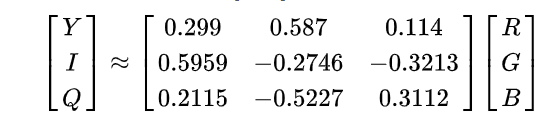



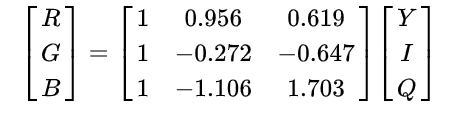

In [ ]:
from skimage import img_as_float
yiq_from_rgb = np.array([[0.299     ,0.587      ,     0.114],
                      [0.59590059,-0.27455667,-0.32134392],
                      [0.21153661, -0.52273617,0.31119955]])
rgb_from_yiq=np.linalg.inv(yiq_from_rgb)
def RGB_to_YIQ(image):
  image=img_as_float(image)         # this coverts all the values of an image to [0,1]
  image=image.dot(yiq_from_rgb.T)   #
  return image
def YIQ_to_RGB(image):
  image=img_as_float(image)
  image=image.dot(rgb_from_yiq.T)
  return image

Testing the above functions


""

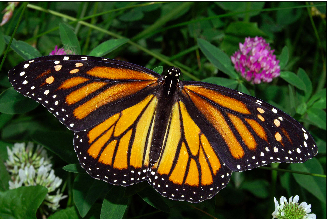

The Original image


""

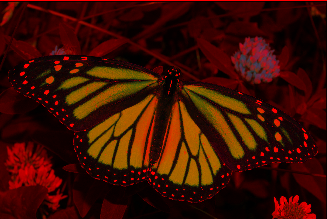

Image converted to YIQ


""

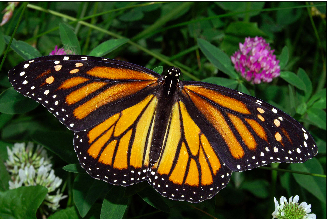

Image converted back to RGB


In [ ]:
print("Testing the above functions")
image = media.read_image('/content/image1.jpg')
media.show_image(image, height=300, border=True)
print("The Original image")
img=RGB_to_YIQ(image)
media.show_image(img, height=300, border=True)
print("Image converted to YIQ")
img=YIQ_to_RGB(img)
media.show_image(img, height=300, border=True)
print("Image converted back to RGB")

####Reading and Writing Video File

In [ ]:
from imageio import get_reader, get_writer
def load_video(filename):
    reader = get_reader(filename)
    orig_vid = []
    for i, im in enumerate(reader):
        orig_vid.append(im)
    return np.asarray(orig_vid)
def write_video(location,result,FPS):
  media.write_video('location', result, fps=FPS)
  media.show_video(result)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Temporal Filters

####Amplitude Weighted Blur

For each band i of the representation and each frame k , we have phase signal phi(i,k) and amplitude A(i,k) we apply  a weighted gaussian blurr


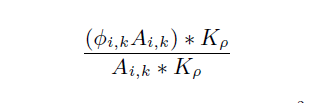

where kp is
 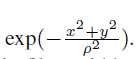

In [ ]:
from skimage.filters import gaussian
def amplitude_weighted_blur(x, weight, sigma):
    if sigma != 0:
        return gaussian(x*weight, sigma, mode="wrap") / gaussian(weight, sigma, mode="wrap")
    return x

# where x is phase of the frame ,weight is total amplitude of the frame , sigma is Standard deviation for Gaussian kernel
# The mode parameter determines how the array borders are handled

""

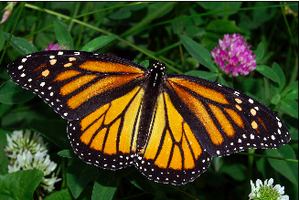

value of sigma is : 1


""

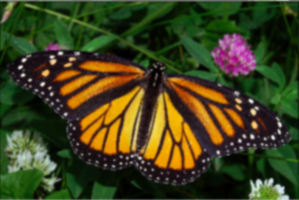

value of sigma is : 21


""

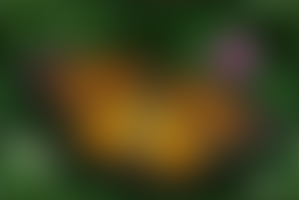

value of sigma is : 41


""

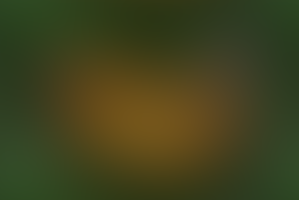

value of sigma is : 61


""

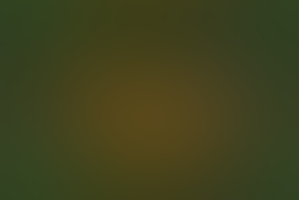

In [ ]:
media.show_image(image,height=200)
for i in range(1,62,20):
  print("value of sigma is : " + str(i))
  x=gaussian(image,sigma=i,mode="wrap")
  media.show_image(x,height=200)

####Difference of infinite impulse response

In [ ]:
def difference_of_iir(delta, rl, rh):

    lowpass_1 = delta[0].copy()
    lowpass_2 = lowpass_1.copy()
    out = zeros(delta.shape, dtype=delta.dtype)
    for i in range(1, delta.shape[0]):
        lowpass_1 = (1-rh)*lowpass_1 + rh*delta[i]
        lowpass_2 = (1-rl)*lowpass_2 + rl*delta[i]
        out[i] = lowpass_1 - lowpass_2
    return out

#Complex Steerable Filters

####Simplify Phase and maximum pyamid height

In [ ]:
import math
from numpy import *

def simplify_phase(x):
   #Moves x into the [-pi, pi] range.
    temp= ((x + pi) % (2*pi)) - pi
    return temp

def max_scf_pyr_height(dims):
  #Gets the maximum possible steerable pyramid height
   # dims: (h, w), the height and width of  desired filters in a tuple
	return int(log2(min(dims[:2]))) - 2


In [ ]:
for i in range(-4,4,1):
  x=simplify_phase(i*pi)
  print(x)
# coverts even multiple of pi into 0 and old into -pi

0.0
-3.141592653589793
0.0
-3.141592653589793
0.0
-3.141592653589793
0.0
-3.141592653589793


####Get Filters Smooth Window
(A complex steerable filter generator with a smoother window. Better for quarter octave or half octave decompositions.)

In [ ]:
def get_polar_grid(dims):
    center = ceil((array(dims))/2).astype(int)
    xramp, yramp = meshgrid(linspace(-1, 1, dims[1]+1)[:-1], linspace(-1, 1, dims[0]+1)[:-1])
    theta = arctan2(yramp, xramp)
    r = sqrt(xramp**2 + yramp**2)

    # eliminate the zero at the center
    r[center[0], center[1]] = min((r[center[0], center[1]-1], r[center[0]-1, center[1]]))/2
    return theta,r

def get_angle_mask_smooth(index, num_bands, angle, is_complex):
    order = num_bands-1
    const = sqrt((2**(2*order))*(math.factorial(order)**2)/(num_bands*math.factorial(2*order)))
    angle = simplify_phase(angle+(pi*index/num_bands))

    if is_complex:
        return const*(cos(angle)**order)*(abs(angle) < pi/2)
    else:
        return abs(sqrt(const)*(cos(angle)**order))

def get_filters_smooth_window(dims, orientations, cos_order=6, filters_per_octave=6, is_complex=True, pyr_height=-1):
    """
    A complex steerable filter generator with a smoother window. Better for quarter octave or half octave decompositions.
    """
    max_pyr_height = max_scf_pyr_height(dims)                                   #calculating maxpyramid height that we can take from dim ie. (h,w)
    if( pyr_height == -1 or pyr_height > max_pyr_height):
        pyr_height = max_pyr_height
    total_filter_count = filters_per_octave * pyr_height                        #total fileters is (height of pyramid)*(filters per octave)

    theta, r = get_polar_grid(dims)
    r = (log2(r) + pyr_height)*pi*(0.5 + (total_filter_count / 7)) / pyr_height

    window_function = lambda x, c: (abs(x - c) < pi/2).astype(int)
    compute_shift = lambda k: pi*(k/(cos_order+1)+2/7)

    rad_filters = []

    total = zeros(dims)
    a_constant = sqrt((2**(2*cos_order))*(math.factorial(cos_order)**2)/((cos_order+1)*math.factorial(2*cos_order)))
    for k in range(total_filter_count):
        shift = compute_shift(k+1)
        rad_filters += [a_constant*(cos(r-shift)**cos_order)*window_function(r,shift)]
        total += rad_filters[k]**2
    rad_filters = rad_filters[::-1]

    center = ceil(array(dims)/2).astype(int)
    low_dims = ceil(array(center+1.5)/4).astype(int)
    total_cropped = total[center[0]-low_dims[0]:center[0]+low_dims[0]+1, center[1]-low_dims[1]:center[1]+low_dims[1]+1]

    low_pass = zeros(dims)
    low_pass[center[0]-low_dims[0]:center[0]+low_dims[0]+1, center[1]-low_dims[1]:center[1]+low_dims[1]+1] = abs(sqrt(1+0j-total_cropped))
    total += low_pass**2
    high_pass = abs(sqrt(1+0j-total))

    anglemasks = []
    for i in range(orientations):
        anglemasks += [get_angle_mask_smooth(i, orientations, theta, is_complex)]

    out = [high_pass]
    for i in range(len(rad_filters)):
        for j in range(len(anglemasks)):
            out += [anglemasks[j]*rad_filters[i]]
    out += [low_pass]
    return out

In [ ]:
(h,w)=(300,300)
filters=get_filters_smooth_window((h, w), 8, filters_per_octave=2)
len(filters)


98

After Processing


""

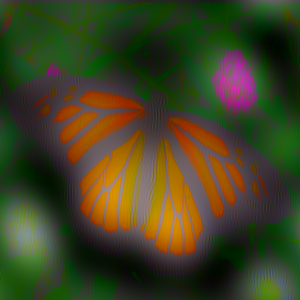

Before Processing


""

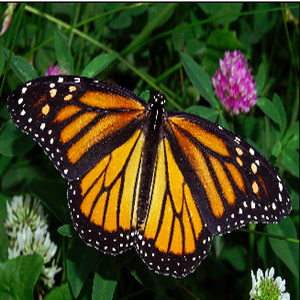

In [ ]:

import pyfftw.interfaces.scipy_fftpack as spfft
import skimage.transform as sktransform
temporal_filter=difference_of_iir
img=RGB_to_YIQ(image)                                                           #rgb to yiq image

img=sktransform.resize(img, (300,300))                                          #resized the image to 300,300

fft_img = spfft.fftshift(spfft.fft2(img[:,:,0]))                                #working on y channel only  find 2d fourier transform of the image
                                                                                #and using fftshift bringing 0 frequency component to the center

dc_frame = spfft.ifft2(spfft.ifftshift(filters[1]*fft_img))    #applying filters then inverse fftshift and then inverse fourier transform
dc_frame_no_mag = dc_frame / np.abs(dc_frame)                  #calculating magnitude of the image
dc_frame_phase = np.angle(dc_frame)                            #phase of the image
#print((dc_frame.shape))
total = simplify_phase(dc_frame_phase)                         #bringing phase between (-pi,pi)

total = temporal_filter(total, 0.04, 0.4).astype(float)        #applying temporal filter
phase_of_frame=total
phase_of_frame = amplitude_weighted_blur(phase_of_frame, np.abs(dc_frame), 5) #applying smoothning on the temporal filtered phase
#print(phase_of_frame[0][0])
magnification_factor=50
phase_of_frame *= magnification_factor                              #multiplying with magnification factor
#print(phase_of_frame[0][0])

magnified_component = 2*filters[1]*spfft.fftshift(spfft.fft2(dc_frame*np.exp(1j*phase_of_frame)))
magnified_y_channel = magnified_component

magnified_y_channel = magnified_y_channel + (fft_img*(filters[-1]**2))

out_frame  = np.dstack((np.real(spfft.ifft2(spfft.ifftshift(magnified_y_channel))), img[:,:,1:3]))
#print(out_frame)
out=YIQ_to_RGB(out_frame)
print("After Processing")
media.show_image(out)
print("Before Processing")
media.show_image(image ,height=300,width=300)

####Get Filters

In [ ]:
def get_radial_mask_pair(r, rad, t_width):
    log_rad = log2(rad)-log2(r)
    hi_mask = abs(cos(log_rad.clip(min=-t_width, max=0)*pi/(2*t_width)))
    lo_mask = sqrt(1-(hi_mask**2))
    return (hi_mask, lo_mask)

def get_angle_mask(b, orientations, angle):
    order = orientations - 1
    a_constant = sqrt((2**(2*order))*(math.factorial(order)**2)/(orientations*math.factorial(2*order)))
    angle2 = simplify_phase(angle - (pi*b/orientations))
    return 2*a_constant*(cos(angle2)**order)*(abs(angle2) < pi/2)

def get_filters(dims, r_vals=None, orientations=4, t_width=1):
    """
    Gets a steerbale filter bank in the form of a list of ndarrays
    dims: (h, w). Dimensions of the output filters. Should be the same size as the image you're using these to filter
    r_vals: The boundary between adjacent filters. Should be an array.
        e.g.: 2**np.array(list(range(0,-7,-1)))
    orientations: The number of filters per level
    t-width: The falloff of each filter. Smaller t_widths correspond to thicker filters with less falloff
    """
    if r_vals is None:
        r_vals = 2**np.array(list(range(0,-max_scf_pyr_height(dims)-1,-1)))
    angle, r = get_polar_grid(dims)
    hi_mask, lo_mask_prev = get_radial_mask_pair(r_vals[0], r, t_width)
    filters = [hi_mask]
    for i in range(1, len(r_vals)):
        hi_mask, lo_mask = get_radial_mask_pair(r_vals[i], r, t_width)
        rad_mask = hi_mask * lo_mask_prev
        for j in range(orientations):
            angle_mask = get_angle_mask(j, orientations, angle)
            filters += [rad_mask*angle_mask/2]
        lo_mask_prev = lo_mask
    filters += [lo_mask_prev]
    return filters

In [ ]:
(h,w)=(300,300)
pyr_height = max_scf_pyr_height((h, w))
filters=get_filters((h, w), 2**np.array(list(range(0,-pyr_height-1,-1)), dtype=float), 4)
len(filters)


26

After Processing


""

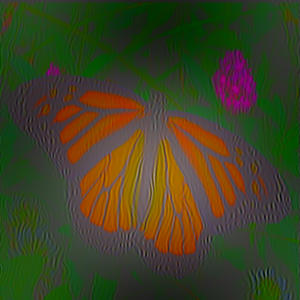

Before Processing


""

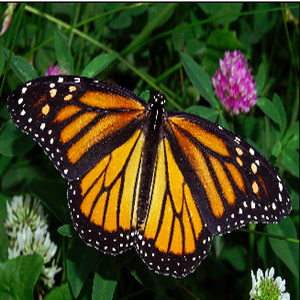

In [ ]:
import pyfftw.interfaces.scipy_fftpack as spfft
import skimage.transform as sktransform
temporal_filter=difference_of_iir
img=RGB_to_YIQ(image)                                                           #rgb to yiq image

img=sktransform.resize(img, (300,300))                                          #resized the image to 300,300

fft_img = spfft.fftshift(spfft.fft2(img[:,:,0]))                                #working on y channel only  find 2d fourier transform of the image
                                                                                #and using fftshift bringing 0 frequency component to the center

dc_frame = spfft.ifft2(spfft.ifftshift(filters[1]*fft_img))    #applying filters then inverse fftshift and then inverse fourier transform
dc_frame_no_mag = dc_frame / np.abs(dc_frame)                  #calculating magnitude of the image
dc_frame_phase = np.angle(dc_frame)                            #phase of the image
#print((dc_frame.shape))
total = simplify_phase(dc_frame_phase)                         #bringing phase between (-pi,pi)

total = temporal_filter(total, 0.04, 0.4).astype(float)        #applying temporal filter
phase_of_frame=total
phase_of_frame = amplitude_weighted_blur(phase_of_frame, np.abs(dc_frame), 5) #applying smoothning on the temporal filtered phase
#print(phase_of_frame[0][0])
magnification_factor=50
phase_of_frame *= magnification_factor                              #multiplying with magnification factor
#print(phase_of_frame[0][0])

magnified_component = 2*filters[1]*spfft.fftshift(spfft.fft2(dc_frame*np.exp(1j*phase_of_frame)))
magnified_y_channel = magnified_component

magnified_y_channel = magnified_y_channel + (fft_img*(filters[-1]**2))

out_frame  = np.dstack((np.real(spfft.ifft2(spfft.ifftshift(magnified_y_channel))), img[:,:,1:3]))
#print(out_frame)
out=YIQ_to_RGB(out_frame)
print("After Processing")
media.show_image(out)
print("Before Processing")
media.show_image(image ,height=300,width=300)

#Main Algorithm
Pseudo Code

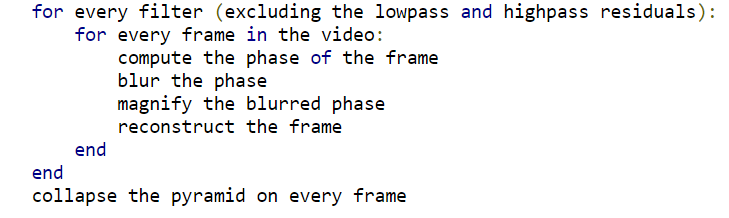

In [ ]:
def phase_amplify(video, magnification_factor, fl, fh, fs, attenuate_other_frequencies=False, pyramid_type="octave", sigma=0, temporal_filter=difference_of_iir):
    num_frames, h, w, num_channels = video.shape
    pyr_height = max_scf_pyr_height((h, w))

    if pyr_type is "octave":
        print("Using vanilla octave pyramid")
        filters = get_filters((h, w), 2**np.array(list(range(0,-pyr_height-1,-1)), dtype=float), 4)
    elif pyr_type is "halfOctave":
        print("Using half octave pyramid")
        filters = get_filters((h, w), 2**np.array(list(range(0,-pyr_height-1,-1)), dtype=float), 8, t_width=0.75)
    elif pyr_type is "smoothHalfOctave":
        print("Using smooth half octave pyramid.")
        filters = get_filters_smooth_window((h, w), 8, filters_per_octave=2)
    elif pyr_type is "quarterOctave":
        print("Using quarter octave pyramid.")
        filters = get_filters_smooth_window((h, w), 8, filters_per_octave=4)
    else:
        print("Invalid filter type. Specify ocatave, halfOcatave, smoothHalfOctave, or quarterOctave")
        return None
    yiq_video = np.zeros((num_frames, h, w, num_channels))
    fft_video = np.zeros((num_frames, h, w), dtype=complex64)

    for i in range(num_frames):
        yiq_video[i] = RGB_to_YIQ(video[i])
        fft_video[i] = spfft.fftshift(spfft.fft2(yiq_video[i][:,:,0]))

    magnified_y_channel = np.zeros((num_frames, h, w), dtype=complex64)
    dc_frame_index = 0
    for i in range(1,len(filters)-1):
        print("processing level "+str(i))

        dc_frame = spfft.ifft2(spfft.ifftshift(filters[i]*fft_video[dc_frame_index]))
        dc_frame_no_mag = dc_frame / np.abs(dc_frame)
        dc_frame_phase = np.angle(dc_frame)

        total = np.zeros(fft_video.shape, dtype=float)
        filtered = np.zeros(fft_video.shape, dtype=complex64)

        for j in range(num_frames):
            filtered[j] = spfft.ifft2(spfft.ifftshift(filters[i]*fft_video[j]))
            total[j] = simplify_phase(np.angle(filtered[j]) - dc_frame_phase)

        print("bandpassing...")
        total = temporal_filter(total, fl/fs, fh/fs).astype(float)

        for j in range(num_frames):
            phase_of_frame = total[j]
            if sigma != 0:
                phase_of_frame = amplitude_weighted_blur(phase_of_frame, np.abs(filtered[j]), sigma)

            phase_of_frame *= magnification_factor

            if attenuate_other_frequencies:
                temp_orig = np.abs(filtered[j])*dc_frame_no_mag
            else:
                temp_orig = filtered[j]
            magnified_component = 2*filters[i]*spfft.fftshift(spfft.fft2(temp_orig*np.exp(1j*phase_of_frame)))

            magnified_y_channel[j] = magnified_y_channel[j] + magnified_component

    for i in range(num_frames):
            magnified_y_channel[i] = magnified_y_channel[i] + (fft_video[i]*(filters[-1]**2))

    out = np.zeros(yiq_video.shape)

    for i in range(num_frames):
        out_frame  = np.dstack((np.real(spfft.ifft2(spfft.ifftshift(magnified_y_channel[i]))), yiq_video[i,:,:,1:3]))
        out[i] = YIQ_to_RGB(out_frame)

    return out.clip(min=0, max=1)

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-71-cb9a0e03bb52>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if pyr_type is "octave":
<ipython-input-71-cb9a0e03bb52>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif pyr_type is "halfOctave":
<ipython-input-71-cb9a0e03bb52>:11: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif pyr_type is "smoothHalfOctave":
<ipython-input-71-cb9a0e03bb52>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif pyr_type is "quarterOctave":


#Input and Pre-Processing

In [ ]:
video_file = "/content/drive/MyDrive/Screencastify/eye.avi"
video = load_video(video_file)
video_resized = np.zeros((len(video), 250, 250, 3))
for i in range(len(video)):
    video_resized[i] = sktransform.resize(video[i], (250,250))

#Parameters and Results

In [ ]:
magnification_factor = 20
fl = .04 #bandpass
fh = .4
fs = 1
attenuate_other_frequencies=True
pyr_type = "octave"
sigma = 5
temporal_filter = difference_of_iir
scale_video = .8

In [ ]:
result=phase_amplify(video_resized, magnification_factor, fl, fh, fs, attenuate_other_frequencies=attenuate_other_frequencies, pyramid_type=pyr_type, sigma=sigma, temporal_filter=temporal_filter)

Using vanilla octave pyramid
processing level 1
bandpassing...
processing level 2
bandpassing...
processing level 3
bandpassing...
processing level 4
bandpassing...
processing level 5
bandpassing...
processing level 6
bandpassing...
processing level 7
bandpassing...
processing level 8
bandpassing...
processing level 9
bandpassing...
processing level 10
bandpassing...
processing level 11
bandpassing...
processing level 12
bandpassing...
processing level 13
bandpassing...
processing level 14
bandpassing...
processing level 15
bandpassing...
processing level 16
bandpassing...
processing level 17
bandpassing...
processing level 18
bandpassing...
processing level 19
bandpassing...
processing level 20
bandpassing...


In [ ]:
media.show_video(video_resized)
media.show_video(result)